# HW1 Q3 - Convolutional Neural Networks

In this question, we set up a CNN in order to perform the 'Cats vs Dogs' Kaggle challenge

First, we import some PyTorch libraries and direct them to use Google Colab's GPU:

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Sampler, Dataset
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
from torch.autograd import Variable

import os
import numpy as np
import PIL.Image
import glob
import matplotlib.pyplot as plt


In [0]:
# Use the GPU
device = torch.device('cuda')

In order to import the data for Kaggle from Google Drive, we need to jump through a few hoops, as seen below

In [0]:
# Import the data

from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
PATH = '/content/drive/My Drive/DL_A1/'


# apply several different transforms, as necessary
rotate = [-90, 90]
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(rotate),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomResizedCrop(64, scale=(0.75, 1.0)),
    transforms.ToTensor()
])

# for the hyperparameter tunning, no transforms were applied

# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor()
# ])

# load the data, which was downloaded and saved 
Data = np.load(PATH +'data.npz')



In [0]:

# we define the dataset class for the train, valid and test data
class dataset(Dataset):
  def __init__(self, X, Y, transform=None):
    self.X = X
    self.Y = Y
    self.transform = transform
  
  def __len__(self):
    return self.X.shape[0]
  
  def __getitem__(self, index):
    #temp = self.transform(self.X[index,:])
    #return temp, self.Y[index]\
    sequence, target = self.X[index], self.Y[index]
    if self.transform is not None:
      sequence = self.transform(sequence)
    if target is None:
      return sequence
    return sequence, target



In [0]:
# define the labels and datasets

test_labels = [None]*Data['Xte'].shape[0]
train_dataset = dataset(Data['Xtr'], Data['y'], transform)
test_dataset = dataset(Data['Xte'], test_labels, transform)
testIDS_list = np.hsplit(Data['testIds'], 1)
testIDS = testIDS_list[0]

In [0]:
# we will define this information now 
batch_size = 64
learning_rate = 0.005
num_epochs = 100

num_classes = 2
num_of_workers = 4

To split the training data into a training and validation set, we need to establish a `sampler` for each that will pull out certain samples when called from the dataloader. In our case, we have a 20% validation split, with 16000 training examples and 4000 validation examples.

In [0]:
# Define a shuffled train and valid index list (non-overlapping)

a = np.arange(19998)
np.random.shuffle(a)

num_train_samples = 16000
num_valid_samples = 19998 - num_train_samples

train_index = a[:num_train_samples]
valid_index = a[num_train_samples:
                num_train_samples+num_valid_samples]


In [0]:

# Fix seed
np.random.seed(42)
torch.manual_seed(42)

# Define samplers for the data (to get validation split)

train_sampler = SubsetRandomSampler(train_index)

valid_sampler = SubsetRandomSampler(valid_index)




As a last step before training, we define training, validation, and test dataloaders that sample from the above `sampler`s according to the defined batch size:

In [0]:

# Get dataloaders for train/valid/test
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          sampler=valid_sampler)


## CNN architecture definition

Now we define the class for our CNN.

In [0]:
# this is just a function to help with input/output size
def output_size(input_size, kernel_size, stride, padding):
    '''
    Helper function to determine output size of a convolution/pooling.
    '''
    output = int((input_size - kernel_size + 2*(padding)) / stride) + 1
    return output

In [0]:

# hyperparameter tunning 
# Define the CNN class

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 40, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    self.conv2 = nn.Conv2d(40, 40, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    self.fc1 = nn.Linear(10240, 175)
    self.fc2 = nn.Linear(175, 2)
   
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(len(x), 10240)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
#     x = F.softmax(x)nYT `yyb5

    return x
  

    

This CNN has two convolutional layers, each with a ReLU activation, a kernel size of 3, a stride of 1, and a padding level of 1. The first convolutional layer learns 18 feature maps and the second learns 64 feature maps. Both convolutional layers use max pooling after their operation, with a kernel size of 2 and stride of 2.
During hyperparameter tuning, these values were modified

Finally, the data will pass through two fully connected layers and output to 2 units representing either a 'Cat' or a 'Dog'.

Below, we see an outline of this architecture. Note that the total number of trainable parameters is around 1.8 million per sample


In [0]:
model = CNN().to(device)
print(model)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameters: {}'.format(params))

CNN(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10240, out_features=175, bias=True)
  (fc2): Linear(in_features=175, out_features=2, bias=True)
)
Number of parameters: 1808087


## CNN training

Now we will define our loss function and stochastic gradient descent optimizer, and run over the training loop for our CNN.

In [0]:
# Define loss and optimizer

# depending on the method, either NLL or cross entropy loss was used (the latter includes a softmax)
# the former allows for easy visualization of the data
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


seed weight for reproducibility
Please note: originally, the code was run without a seed. We do understand that initial values are important in order to allow for reproducibility, but it wasn't done early enough to allow for seeding. As a result, while the code is set up for seeding the weights, running the code might not give the desired results on the first run.



In [0]:
# initialize seed weights for reproducability
if type(CNN) in [nn.Conv2d, nn.Linear, nn.MaxPool2d ]:
  CNN.weight.data = normal_(1.0, 0.02)
  CNN.bias.data = fill_(0)


# Below is the training and validation loop

In [0]:
# Make a nice progress bar - tqdm on colab is a bit buggy though
from tqdm import tqdm
best_val_acc = 0
# Train
print('\nBeginning training.')
total_step = len(train_loader)
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  # Training set
  model.train()
  total_tr, correct_tr = 0, 0
  total_val, correct_val = 0, 0
  mean_train_loss = 0.0
  mean_valid_loss = 0.0
  mean_train_acc = 0.0
  mean_valid_acc = 0.0
  
  output_clear = []
  output_ambig = []
  misclass = []
  for i, (images, labels) in enumerate(tqdm(train_loader, position=0)):
    
    labels = torch.max(labels, 1)[1]
    images, labels = images.to(device), labels.long().to(device)
    optimizer.zero_grad()
   

    # Forward
    outputs = model(images)
    
    # Check if classifications are close (ambiguous) or far apart (clear)
    for j in range(outputs.shape[0]):
      outputs_cpu = outputs.cpu().detach().numpy()
      if abs(outputs_cpu[j,1]-outputs_cpu[j,0] > 0.4):
        output_clear.append(images[j].cpu().numpy())
      if abs(outputs_cpu[j,1]-outputs_cpu[j,0] < 0.1):
        output_ambig.append(images[j].cpu().numpy())
        
       
    loss = criterion(outputs, labels) 
    



# try this implementation
    lambda1 = 0.5
    lambda2 = 2.75
    l1_regularization, l2_regularization = torch.tensor(0), torch.tensor(0)
#     for param in model.parameters():
#       l1_regularization += torch.norm(param, 1).long()
#       l2_regularization += torch.norm(param, 2).long()
#     loss = criterion(outputs, labels) + lambda2 * l2_regularization
    mean_train_loss += loss
  
    # Backward
    loss.backward()
    optimizer.step()
    
#     modify learning rate, if desired
#     if epoch%200 == 0:
#       learning_rate = learning_rate/5
#       optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Track loss and accuracy
    
    total_tr += labels.size(0)
    _, predicted_tr = torch.max(outputs.data, 1)
    correct_tr += (predicted_tr == labels).sum().item()
    incorrect_tr = (predicted_tr != labels).cpu().detach().numpy()
    
    # Keep track of wrongly classified items
    for k in range(outputs.shape[0]):
      if incorrect_tr[k] == 1: # If misclassified
        misclass.append(images[k].cpu().numpy())
    acc_tr = correct_tr/total_tr
    mean_train_acc += acc_tr

  
  mean_train_loss /= i+1
  mean_train_acc /= i+1
  pred_total = 0
  labels_total = 0
  
  # Validation set
  model.eval()
  for i, (images, labels) in enumerate(valid_loader):

    labels = torch.max(labels, 1)[1]
    images, labels = images.to(device), labels.long().to(device)
    valid_outputs = model(images)
    valid_loss = criterion(valid_outputs, labels)
    mean_valid_loss += valid_loss
    
    total_val += labels.size(0)
    _, predicted_val = torch.max(valid_outputs.data, 1)
    correct_val += (predicted_val == labels).sum().item()
    valid_acc = correct_val/total_val
    mean_valid_acc += valid_acc
  mean_valid_loss /= i+1
  mean_valid_acc /= i+1
  
  
  
  train_losses.append(mean_train_loss.item())
  train_accuracies.append(mean_train_acc)
  valid_losses.append(mean_valid_loss.item())
  valid_accuracies.append(mean_valid_acc)
  # Mod this when num epochs is too big
  print('\ntrain_loss: {}, train_acc: {}, valid_loss: {}, valid_acc: {}'.format(
      mean_train_loss.item(), mean_train_acc*100, mean_valid_loss.item(), mean_valid_acc*100))
  


  0%|          | 0/250 [00:00<?, ?it/s]


Beginning training.
Epoch 1/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6930121183395386, train_acc: 49.314395202199854, valid_loss: 0.6922060251235962, valid_acc: 58.66403394186458
Epoch 2/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6921491622924805, train_acc: 52.928826578483545, valid_loss: 0.6913283467292786, valid_acc: 52.99855408087988
Epoch 3/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6915544271469116, train_acc: 54.44936447441978, valid_loss: 0.6908679604530334, valid_acc: 57.65661955998391
Epoch 4/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6906049847602844, train_acc: 54.53327361872233, valid_loss: 0.6900164484977722, valid_acc: 54.08189188128782
Epoch 5/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6896219849586487, train_acc: 55.04689551216223, valid_loss: 0.689870297908783, valid_acc: 52.39738052638747
Epoch 6/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6886937022209167, train_acc: 55.37982925407615, valid_loss: 0.6879338622093201, valid_acc: 55.99467022323358
Epoch 7/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6874176263809204, train_acc: 56.14729450652665, valid_loss: 0.6856641173362732, valid_acc: 55.894912230207304
Epoch 8/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6857605576515198, train_acc: 56.849689025677066, valid_loss: 0.6855896711349487, valid_acc: 54.87658033529469
Epoch 9/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6837629675865173, train_acc: 56.801494015848455, valid_loss: 0.6830567121505737, valid_acc: 58.020764941676774
Epoch 10/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6819365620613098, train_acc: 56.72911152567145, valid_loss: 0.6778761744499207, valid_acc: 59.9584276491097
Epoch 11/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6789121627807617, train_acc: 58.10357402919267, valid_loss: 0.6780409812927246, valid_acc: 56.242606349332206
Epoch 12/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6768230199813843, train_acc: 58.03116565818828, valid_loss: 0.673999011516571, valid_acc: 59.131976420507684
Epoch 13/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6733040809631348, train_acc: 58.53903639656481, valid_loss: 0.6681304574012756, valid_acc: 60.27303232233832
Epoch 14/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6705248951911926, train_acc: 59.92597771768134, valid_loss: 0.6714690327644348, valid_acc: 59.09437970466283
Epoch 15/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6681783199310303, train_acc: 59.36043034110546, valid_loss: 0.6618127822875977, valid_acc: 61.30249952622291
Epoch 16/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6645616292953491, train_acc: 59.19026676059376, valid_loss: 0.6601235270500183, valid_acc: 60.807485224627364
Epoch 17/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.661151111125946, train_acc: 60.97584981969407, valid_loss: 0.6584104299545288, valid_acc: 61.141761566468276
Epoch 18/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6594252586364746, train_acc: 60.63015353711819, valid_loss: 0.655601978302002, valid_acc: 61.57337699647314
Epoch 19/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6556634306907654, train_acc: 61.14602675077594, valid_loss: 0.6502322554588318, valid_acc: 61.91810392062339
Epoch 20/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6521233320236206, train_acc: 61.16133553981744, valid_loss: 0.6475959420204163, valid_acc: 62.386763809905766
Epoch 21/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6485194563865662, train_acc: 61.422656641786574, valid_loss: 0.6502894759178162, valid_acc: 62.128569852028924
Epoch 22/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6481691598892212, train_acc: 61.88047765871516, valid_loss: 0.6658605933189392, valid_acc: 57.560629760466966
Epoch 23/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6418377161026001, train_acc: 62.722220078472915, valid_loss: 0.6344516277313232, valid_acc: 64.23504281406858
Epoch 24/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6376298069953918, train_acc: 63.42318671440883, valid_loss: 0.6347023248672485, valid_acc: 63.69759200256361
Epoch 25/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6335791349411011, train_acc: 64.06509181113341, valid_loss: 0.6446325182914734, valid_acc: 62.815992847237986
Epoch 26/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6327356100082397, train_acc: 63.87866794854587, valid_loss: 0.6256667971611023, valid_acc: 66.03924657114743
Epoch 27/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6266655921936035, train_acc: 64.62191800757658, valid_loss: 0.6335140466690063, valid_acc: 60.985005328140375
Epoch 28/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6236879229545593, train_acc: 65.7409744461335, valid_loss: 0.6228858828544617, valid_acc: 64.53008891977223
Epoch 29/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6202166080474854, train_acc: 64.83716796759484, valid_loss: 0.6181164383888245, valid_acc: 64.19272977397841
Epoch 30/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.61729496717453, train_acc: 65.79242024220596, valid_loss: 0.6197649836540222, valid_acc: 65.68643211735427
Epoch 31/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6137694716453552, train_acc: 66.5953366822401, valid_loss: 0.6120125651359558, valid_acc: 66.5655484907245
Epoch 32/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6122452020645142, train_acc: 67.65941095739907, valid_loss: 0.6140419244766235, valid_acc: 66.56710949748904
Epoch 33/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6095800995826721, train_acc: 65.93340814036486, valid_loss: 0.6128605008125305, valid_acc: 65.82804250148943
Epoch 34/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6097579002380371, train_acc: 67.04169613538042, valid_loss: 0.606428861618042, valid_acc: 67.42689462919206
Epoch 35/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.607787013053894, train_acc: 66.88630270652962, valid_loss: 0.6062102913856506, valid_acc: 66.46242548240346
Epoch 36/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6048984527587891, train_acc: 67.9075465211183, valid_loss: 0.6138296127319336, valid_acc: 65.72992383455325
Epoch 37/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6039204597473145, train_acc: 67.41575333353587, valid_loss: 0.6197585463523865, valid_acc: 65.06953543879995
Epoch 38/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6028443574905396, train_acc: 67.33646848627698, valid_loss: 0.6015389561653137, valid_acc: 68.71864314337994
Epoch 39/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6017124652862549, train_acc: 67.88737174773924, valid_loss: 0.6142194271087646, valid_acc: 64.99679856756025
Epoch 40/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.598910391330719, train_acc: 67.5044877298936, valid_loss: 0.6117457747459412, valid_acc: 65.81074697515461
Epoch 41/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5957842469215393, train_acc: 68.0626213802651, valid_loss: 0.6120328307151794, valid_acc: 65.76310368927575
Epoch 42/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5973617434501648, train_acc: 67.7018860141793, valid_loss: 0.6035057306289673, valid_acc: 66.44150904510441
Epoch 43/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5958500504493713, train_acc: 68.45245134822065, valid_loss: 0.6001284718513489, valid_acc: 65.73353530008872
Epoch 44/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5935605764389038, train_acc: 68.69343628268547, valid_loss: 0.6020035743713379, valid_acc: 67.7834943206679
Epoch 45/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5934892892837524, train_acc: 67.75969551062764, valid_loss: 0.5953142046928406, valid_acc: 68.70894807122397
Epoch 46/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5903574824333191, train_acc: 69.07831037911014, valid_loss: 0.5943370461463928, valid_acc: 67.67381969001815
Epoch 47/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5899531245231628, train_acc: 68.91544838807754, valid_loss: 0.5945171117782593, valid_acc: 67.83415935045382
Epoch 48/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5887131690979004, train_acc: 69.80008589796121, valid_loss: 0.594160795211792, valid_acc: 67.95792476225947
Epoch 49/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5858006477355957, train_acc: 68.68439765869498, valid_loss: 0.5884914994239807, valid_acc: 69.20729823412391
Epoch 50/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5850964784622192, train_acc: 69.78472803708749, valid_loss: 0.5939870476722717, valid_acc: 68.68204047752118
Epoch 51/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5868164896965027, train_acc: 69.85896289724126, valid_loss: 0.5927030444145203, valid_acc: 68.58049979704565
Epoch 52/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5857794284820557, train_acc: 69.35519021393947, valid_loss: 0.5887488126754761, valid_acc: 68.10641916264086
Epoch 53/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.586605966091156, train_acc: 69.1768610545315, valid_loss: 0.5858736634254456, valid_acc: 69.82766323996626
Epoch 54/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5830691456794739, train_acc: 69.84579295892829, valid_loss: 0.5823893547058105, valid_acc: 67.4449456225232
Epoch 55/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5827730298042297, train_acc: 68.72125916753195, valid_loss: 0.5886029005050659, valid_acc: 66.88081942442837
Epoch 56/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5805429220199585, train_acc: 69.69375286224036, valid_loss: 0.5872617959976196, valid_acc: 69.2984467532464
Epoch 57/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5809487700462341, train_acc: 69.61067033677733, valid_loss: 0.5876259207725525, valid_acc: 67.12170270882528
Epoch 58/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.580505907535553, train_acc: 68.97437501604293, valid_loss: 0.5809106826782227, valid_acc: 69.12762591578168
Epoch 59/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.577383816242218, train_acc: 70.1113631301823, valid_loss: 0.5837250351905823, valid_acc: 69.17388929239473
Epoch 60/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5770896077156067, train_acc: 69.91757844392968, valid_loss: 0.5824355483055115, valid_acc: 69.17982731262215
Epoch 61/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5758497714996338, train_acc: 69.71375743677162, valid_loss: 0.5808229446411133, valid_acc: 69.49924810331346
Epoch 62/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5750714540481567, train_acc: 70.75182440179053, valid_loss: 0.5767399668693542, valid_acc: 70.00923127194143
Epoch 63/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5736591815948486, train_acc: 70.28657081359094, valid_loss: 0.5749519467353821, valid_acc: 68.91844165429644
Epoch 64/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.571812629699707, train_acc: 70.63519695247194, valid_loss: 0.5802775621414185, valid_acc: 68.49641240106746
Epoch 65/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5733658075332642, train_acc: 70.07238153160132, valid_loss: 0.5859566330909729, valid_acc: 67.23655802459194
Epoch 66/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5721427798271179, train_acc: 70.69572155169972, valid_loss: 0.5728212594985962, valid_acc: 70.06780456636722
Epoch 67/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5704730749130249, train_acc: 69.89970072422605, valid_loss: 0.5893929600715637, valid_acc: 67.32697245505643
Epoch 68/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5688832998275757, train_acc: 70.97090793949654, valid_loss: 0.5711925029754639, valid_acc: 69.8106533017786
Epoch 69/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5691027045249939, train_acc: 69.56928835090729, valid_loss: 0.572443962097168, valid_acc: 68.50344906398374
Epoch 70/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5659330487251282, train_acc: 71.35917664072305, valid_loss: 0.5754882097244263, valid_acc: 68.98967825384125
Epoch 71/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5658192038536072, train_acc: 70.22217584606534, valid_loss: 0.5719672441482544, valid_acc: 69.52583618010192
Epoch 72/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5649549961090088, train_acc: 71.29685060051855, valid_loss: 0.574378490447998, valid_acc: 69.48602106065381
Epoch 73/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5615028142929077, train_acc: 72.29682694994779, valid_loss: 0.5647953152656555, valid_acc: 71.28683611522104
Epoch 74/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5632172226905823, train_acc: 71.54913555041034, valid_loss: 0.5648401975631714, valid_acc: 70.0080398494382
Epoch 75/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5618177652359009, train_acc: 70.92412513764907, valid_loss: 0.567070722579956, valid_acc: 70.381281217495
Epoch 76/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5622780323028564, train_acc: 71.78528976281066, valid_loss: 0.5745543241500854, valid_acc: 69.48253452902574
Epoch 77/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5612167716026306, train_acc: 70.74216890301219, valid_loss: 0.5667645931243896, valid_acc: 70.23437260796989
Epoch 78/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5610052347183228, train_acc: 71.63470185614635, valid_loss: 0.5622993111610413, valid_acc: 70.55744503775891
Epoch 79/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5595505833625793, train_acc: 71.7383496269593, valid_loss: 0.5693033337593079, valid_acc: 69.40183781587335
Epoch 80/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5583363771438599, train_acc: 71.42161730581671, valid_loss: 0.5569806098937988, valid_acc: 70.47657741255877
Epoch 81/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.555637001991272, train_acc: 71.24891060024822, valid_loss: 0.5576102137565613, valid_acc: 69.96655608949992
Epoch 82/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5573834776878357, train_acc: 72.1782584468986, valid_loss: 0.5636456608772278, valid_acc: 70.19529193725428
Epoch 83/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5557975769042969, train_acc: 71.67463599709264, valid_loss: 0.5632843971252441, valid_acc: 70.3699653595668
Epoch 84/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5555405020713806, train_acc: 71.46401319627935, valid_loss: 0.5657907724380493, valid_acc: 69.75917127971346
Epoch 85/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5541694164276123, train_acc: 71.6660682904043, valid_loss: 0.5519405603408813, valid_acc: 70.54539107031177
Epoch 86/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5549407601356506, train_acc: 71.7431931811537, valid_loss: 0.5599674582481384, valid_acc: 71.91137503133112
Epoch 87/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5515012741088867, train_acc: 72.07212458738739, valid_loss: 0.5537819266319275, valid_acc: 71.9006366969228
Epoch 88/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5522953867912292, train_acc: 71.71318800250394, valid_loss: 0.5583174228668213, valid_acc: 69.98327483077573
Epoch 89/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5499333143234253, train_acc: 72.28943825157688, valid_loss: 0.5694091320037842, valid_acc: 70.15130796237992
Epoch 90/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5482317805290222, train_acc: 72.94900859187273, valid_loss: 0.556070864200592, valid_acc: 72.92673197095196
Epoch 91/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5493937730789185, train_acc: 72.41779582844838, valid_loss: 0.5505984425544739, valid_acc: 71.11031809820282
Epoch 92/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5481440424919128, train_acc: 72.15947627429397, valid_loss: 0.5496291518211365, valid_acc: 72.1687226393237
Epoch 93/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5488528609275818, train_acc: 72.34628129651078, valid_loss: 0.5478881597518921, valid_acc: 71.77213148973235
Epoch 94/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5438432693481445, train_acc: 72.18167798276313, valid_loss: 0.5504174828529358, valid_acc: 72.73849297030857
Epoch 95/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5489237904548645, train_acc: 72.17943396128017, valid_loss: 0.554957389831543, valid_acc: 72.96431450650506
Epoch 96/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5448395013809204, train_acc: 71.9480304998366, valid_loss: 0.5466194748878479, valid_acc: 72.1712289590207
Epoch 97/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5431017279624939, train_acc: 72.72682526905373, valid_loss: 0.5508442521095276, valid_acc: 70.62943641970323
Epoch 98/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.542725682258606, train_acc: 72.40983524052125, valid_loss: 0.550320565700531, valid_acc: 71.09331174000097
Epoch 99/100


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.5434815883636475, train_acc: 72.73380990996444, valid_loss: 0.5449947118759155, valid_acc: 73.16074314948769
Epoch 100/100


100%|██████████| 250/250 [00:17<00:00, 14.51it/s]



train_loss: 0.543746292591095, train_acc: 72.58211576057138, valid_loss: 0.542112410068512, valid_acc: 72.33382202989152


# In order to plot the images, we will use the following code. Please note that the loops will take a while to run.

In [0]:

output_ambig = np.array(output_ambig)
output_clear = np.array(output_clear)
misclass = np.array(misclass)

# This is inefficient, but works!
ambig_and_wrong, clear_and_wrong = [], []
for item in misclass:
  if item in output_ambig:
    ambig_and_wrong.append(item)
  elif item in output_clear:
    clear_and_wrong.append(item)
    
print('We have',len(ambig_and_wrong),' samples that were misclassified and were ambiguous')
print('We have', len(clear_and_wrong),' samples that were clearly misclassified')


We have 4437  samples that were misclassified and were ambiguous
We have 0  samples that were clearly misclassified


# We can plot the images below. Please note that only some images were chosen for the report

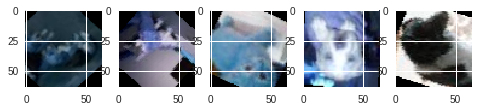

In [0]:

w=20
h=20
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 1
for i in range(5):
  img = np.transpose(ambig_and_wrong[i])
  fig.add_subplot(rows, columns, i + 1)
  plt.imshow(img)
plt.show()


# We can also plot the kernels too, although interpretation is more difficult

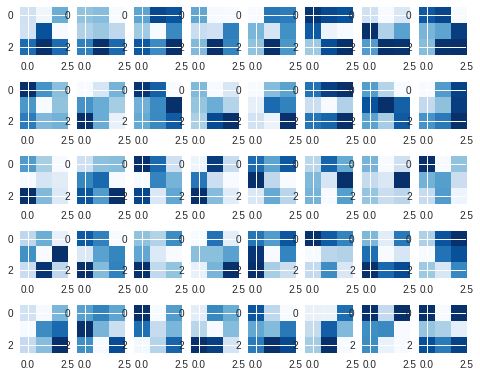

In [0]:
# we can plot the kernels too

def plot_kernels():
  w = 12
  h = 12
  fig=plt.figure(figsize=(8, 8))
  columns = 8
  rows = 6
  weight_cpu = model.conv2.weight.data.cpu()
  weight_np = weight_cpu.detach().numpy()
  for i in range(40):
    img = weight_np[i,0,:,:]
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img, cmap = 'Blues')
  plt.show()

plot_kernels()


# Finally, we can plot the learning curves for our training and validation run

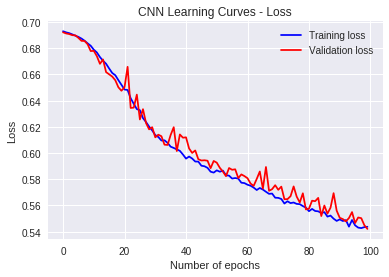

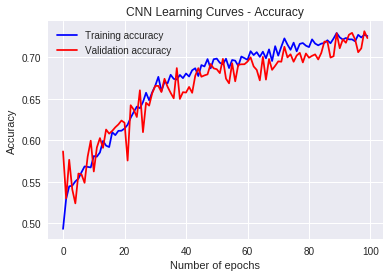

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.title('CNN Learning Curves - Loss')
plt.plot(range(num_epochs), train_losses, color='blue', label='Training loss')
plt.plot(range(num_epochs), valid_losses, color='red', label='Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.title('CNN Learning Curves - Accuracy')
plt.plot(range(num_epochs), train_accuracies, color='blue', label='Training accuracy')
plt.plot(range(num_epochs), valid_accuracies, color='red', label='Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## CNN Testing

Now we evaluate the test performance of our CNN.

Beginning testing
4999


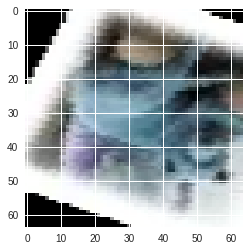

In [0]:
# define the transforms and dataloaders for the test set
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

test_sampler = SequentialSampler(np.arange(len(testIDS)))

test_loader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=batch_size,
                                         sampler=test_sampler)

# Test the model
model.eval()
with torch.no_grad():
  count = 1
  for images in test_loader: 
 
    just_image = images[0,:,:,:]
    a = np.transpose(just_image)
    plt.imshow(a)
    
    
    images = images.to(device)
    outputs = model(images)
    
#     convert and stack outputs
    outputs_cpu = outputs.cpu()
    temp = outputs_cpu.detach().numpy()
    if count == 1:
      test_out = temp
    else:
      test_out = np.vstack((test_out, temp))  

    count += 1
print('Beginning testing')
print(len(test_out))

In [0]:
# pickle and save results to submit for kaggle

import pandas as pd
import numpy as np
import pickle
import os
import csv

currPath = os.getcwd()
prediction = []
# convert softmax to cat/dog
for i in range(len(test_out)):
  if test_out[i, 0] > test_out[i, 1]:
    prediction.append('Cat')
  else:
    prediction.append('Dog')

    
    
  
# build csv and submit
with open(PATH +'test_predicted.csv', 'w') as csvfile:
    # defined by the sample csv
    fieldnames = ['Id', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(prediction)):
      writer.writerow({'Id': testIDS[i], 'label':prediction[i]})

      